## Латентно семантический анализ


Прежде всего нужна матрица TDM. Принято, что строки  в  матрице TDM с соответствуют  словам, а столбцы — документам. В каждой ячейке матрицы указано какое количество раз слово встречается в соответствующем документе. 


In [111]:
import pandas as pd
import csv
import re
from pymystem3 import Mystem
from yandex_translate import YandexTranslate
translate = YandexTranslate('trnsl.1.1.20171021T160722Z.738acb6379ef8012.5214c13767962890654e18a0d677c343d03bba24')
import nltk
from nltk.corpus import wordnet as wn
import numpy as np
import itertools
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np


In [6]:
#Загружаем русский датасет
text_file = open("OpenData_MinFin_Russia.csv", "r")
lines = text_file.read().split('==Q==')

In [112]:
#Загружаем англ датасет
text_file = open("UK.csv", "r")
uk = text_file.read().split('==Q==')
uk = pd.Series(uk)
uk = uk.map(lambda x: re.sub('\s+', ' ', x))
uk = uk.map(lambda x: re.sub('[^A-Za-zА-Яа-я]', ' ', x))

uk = uk.str.lower()
uk.to_csv('uk2.csv', encoding='utf8')

In [8]:
#Загружаем чилийский датасет

text_file = open("chile.csv", "r")
chile = text_file.read().split('==Q==')
chile = pd.Series(chile)
chile = chile.map(lambda x: re.sub('\s+', ' ', x))
chile = chile.map(lambda x: re.sub('[^A-Za-zА-Яа-я]', ' ', x))

chile = chile.str.lower()
chile.to_csv('chile2.csv', encoding='utf8')

In [9]:
#Берем заранее лематизированные данные с пощью Mystem - я это делал на своем компьютере
ru = pd.Series.empty
ru = pd.Series.from_csv('ru2.csv')
ru = ru[:-1]


In [10]:
#Переводим их на англ.
for i in range(len(ru)):
    ru[i] = translate.translate(ru[i], 'en')['text'][0]

In [11]:
ru.to_csv('ru_translate.csv', encoding='utf8')

In [113]:
#СТАРТ
ru = uk

In [114]:
#Очищаем от запятых
ru=ru.map(lambda x: re.sub('\s+', ' ', x))
ru = ru.map(lambda x: re.sub('[^A-Za-zА-Яа-я]', ' ', x))

In [115]:
#Удаляем стопворды
text_file = open("stop_words.txt", "r")
lines = text_file.read().split('\n')
stopwords = lines[1:-2]
stopwords = set(stopwords)

def replace_stopwords(str_src, stopwords):
    for w in stopwords:
        str_src = str_src.replace(" " + w + " ", " ")
        str_src = str_src.replace("  "," ")
    return str_src
 
# Удаление стоп слов
ru =ru.map(lambda x: replace_stopwords(x, stopwords))

In [50]:
ru_old=ru

In [116]:
#Делаем веторайзер
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(ru)
dtm=X.toarray().transpose()
vocabulary = vectorizer.get_feature_names()
dtm

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [117]:
#Подсчет частот
d = {'vocabulary': vocabulary,'freq': sum(dtm.T),}
freq = pd.DataFrame(data=d)
freq=freq.sort('freq',ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  after removing the cwd from sys.path.


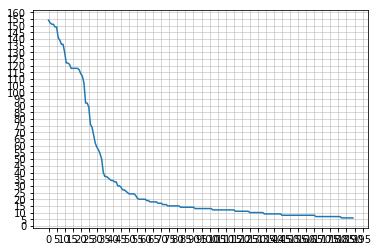

In [66]:
import matplotlib.pyplot as plt

major_ticks = np.arange(0, 200, 5)                                        
minor_ticks = np.arange(0, 200, 5)      
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xticks(major_ticks)                                                       
ax.set_xticks(minor_ticks, minor=True)                                           
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)                                           

# and a corresponding grid                                                       

ax.grid(which='both')                                                            

# or if you want differnet settings for the grids:                               
ax.grid(which='minor', alpha=0.2)                                                
ax.grid(which='major', alpha=0.5)                                                


#plt.grid(color='b', linestyle='-', linewidth=1, alpha =0.3)
plt.plot(freq['freq'].tolist()[10:200])


In [118]:
ux = []
uy = []
d = []
nomer = []
y = freq['freq'].tolist()
x = range(1,len(freq['freq'])+1)
for i in range(len(x)-2):
    d.append(2*(x[i]*(y[i+1]-y[i+2]) + x[i+1]*(y[i+2]-y[i])+x[i+2]*(y[i]-y[i+1])))
    if d[i] !=0:
        ux.append(((x[i]**2+y[i]**2)*(y[i+1]-y[i+2])+(x[i+1]**2+y[i+1]**2)*(y[i+2]-y[i])+(x[i+2]**2+y[i+2])*(y[i]-y[i+1]))/d[i])
        uy.append(((x[i]**2+y[i]**2)*(x[i+2]-x[i+1])+(x[i+1]**2+y[i+1]**2)*(x[i]-x[i+2])+(x[i+2]**2+y[i+2])*(x[i+1]-x[i]))/d[i])
        nomer.append(i)

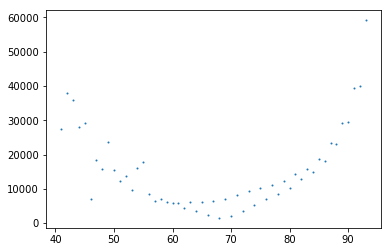

In [119]:
r = []
for i in range(len(nomer)):
    r.append(((ux[i]*-x[i])**2+(uy[i]*-y[i])**2)**0.5)
    
min(r)
np.argmin(r)

plt.scatter(range(1+40,len(r)),r[1-1+40:len(r)-1],s=1)
#plt.plot((0, 8), (10, 10), 'k-')

plt.show()

In [120]:
#выбираем нужные слова
features =freq.reset_index(drop=True)[70:220]
#спиоск фич
features_list = features.T.iloc[1].tolist()

In [121]:
# Достаем индексы фич
index_features=[]
for i, j in enumerate(vocabulary):
    if j in features_list:
        index_features.append(i)
#Матрица финальная
dtm2 =dtm.T[:, index_features]
dtm2=dtm2.T

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [146]:
#Кластеризация
x=[]
y=[]
clusters=5
kmean = KMeans(n_clusters=clusters)
rez=kmean.fit_predict(dtm2) 
silhouette_avg = silhouette_score(dtm2, rez)
x.append(clusters)
y.append(silhouette_avg)
print('clust=',clusters,'silh=',silhouette_avg)

clust= 5 silh= 0.235666047857


In [133]:
#Слова в кластеры

d = {'rez': rez, 'vocabulary': features_list}
df = pd.DataFrame(data=d)
#Слова в кластеры

result =  df.groupby('rez')['vocabulary'].apply(lambda x: "%s" % ', '.join(x))
for i in result:
    print(i)
    print('  ')

scottish, current, liabilities, output, designated, listed, capital, transactions, pensions, welsh, http, gross, number, benefits, year, department, credits, credit, month, student, numbers, spending, performance, farm, payments, estimates, pension, rpi, investment, tables, international, bulletin, provide, payroll, work, savings, analysis, supporting, sme, sheet, material, somerset, labour, cpi, companies, london, industries, including, release, major, retail, publication, collected, main, industry, guid, energy, presents, expenditure, metadata, production, growth, duty, trends, experimental, paid, enterprise, society, cost, term, medium, regions, levels, local, insurance, files, small, stock, trade, range, statistical, product, includes, key, private, input, education, personnel, development, deficit, applications, corporate, producer, sized, indirect, land, registry, goods, time, betting, covers, short, granularity, external, gaming, repayments, sheets, bulletins, inquiry, transacti

In [60]:
#Расширяем и доваляем синонинмы
result_with_sin= result


In [61]:
a = [[3,3],[13,31]]
a[1][0]

13

In [77]:
result_with_syn = []
for i, j in enumerate(result.tolist()):
    result_with_syn.append(j)
#делаем список списков result_with_syn
for i,j in enumerate(result_with_syn):
    result_with_syn[i] = j.split(', ')

In [81]:
def get_syns(word):
    ad=[]
    for synset in wn.synsets(word):
        for lemma in synset.lemmas():
            ad.append(lemma.name())
    return  ', '.join(list(set(ad)))


In [80]:
result_with_syn[0]

['budgetary',
 'consolidated',
 'osmium',
 'foreign',
 'trade',
 'complextype',
 'municipality',
 'real']

In [66]:
result_with_syn_2=result_with_syn

In [134]:
f = open('workfile', 'w')
for i in [['k','as'],['k','aas']]:
    for a in i:
        f.write(a+' ')
    f.write('\n')
f.close()

In [ ]:
f.read()
'This is the entire file.\n'
f.read()

In [82]:
for i,j in enumerate(result_with_syn):
    #print(i,j)
    for k,l in enumerate(j):
        #result_with_syn[i].append(j) #апендим синонимы
        #print(i,k,l)
        result_with_syn[i][k]=get_syns(l)
#result_with_syn_2[:2]

0 0 budgetary
0 1 consolidated
0 2 osmium
0 3 foreign
0 4 trade
0 5 complextype
0 6 municipality
0 7 real
1 0 sector
1 1 document
1 2 accounting
1 3 inspection
1 4 quot
1 5 diamond
1 6 external
1 7 room
1 8 position
1 9 enter
1 10 wastes
1 11 anti
1 12 law
1 13 fax
1 14 standardversion
1 15 entered
2 0 object
2 1 responsible
2 2 symptom
2 3 budgets
2 4 planning
2 5 obligation
2 6 iridium
2 7 ruthenium
2 8 readable
2 9 register
2 10 report
2 11 spent
2 12 receipt
3 0 qualification
3 1 current
3 2 palladium
3 3 services
3 4 product
4 0 set
4 1 statistical
4 2 address
4 3 activity
4 4 classification
4 5 union
4 6 structure
4 7 control
4 8 work
4 9 internal
4 10 institution
4 11 order
4 12 reconstruct
4 13 certificate
4 14 flow
4 15 result
4 16 term
4 17 tax
4 18 payment
4 19 functional
4 20 incision
4 21 activities
4 22 loss
4 23 compilation
4 24 direction
4 25 request
4 26 target
4 27 thous
4 28 spend
4 29 execution
4 30 bank
4 31 date
4 32 republican
4 33 department
4 34 synthetic
4 35 

In [85]:
get_syns('real')

'real, rattling, really, tangible, veridical, material, substantial, very, genuine, literal, existent, real_number, actual'

In [135]:
result_with_syn

[['budgetary',
  'amalgamate, fused, consolidate, consolidated, amalgamated, coalesced',
  'osmium, atomic_number_76, Os',
  'foreign, strange, alien, extraneous',
  'switch, swap, swop, merchandise, patronage, craft, business_deal, trade, trade_in, trade_wind, deal, barter, sell',
  '',
  'municipality',
  'real, rattling, really, tangible, veridical, material, substantial, very, genuine, literal, existent, real_number, actual'],
 ['sector, sphere',
  'written_document, document, text_file, papers',
  'describe, answer_for, accounting, accountancy, method_of_accounting, account_statement, accounting_system, report, calculate, account',
  'inspection, review',
  '',
  'baseball_field, infield, diamond, ball_field, rhombus, baseball_diamond, rhomb, adamant',
  'external, outside, international, extraneous',
  'elbow_room, room, way, board',
  'put, perspective, attitude, billet, place, stead, post, positioning, set, berth, view, situation, placement, office, locating, military_position,

In [146]:
f = open('workfile', 'r')
print(f.readline())

In [ ]:
f = open('workfile', 'w')
for i in result_with_syn:

In [214]:
aaa =[[1,3],[3,41,1]]
aaa[0][1]=[9,2]
aaa
aaa[0]
for x in aaa[0]:
    for y in x:
        flattened_list.append(y)

TypeError: 'int' object is not iterable

In [140]:
import nltk
nltk.__version__

from nltk.corpus import wordnet as wn


In [80]:
#Разбиваем большой кластер
split_big_cluster = result[0].split(', ')
#split_big_cluster=result[0].map(lambda x: re.sub('\s+', ' ', x))

#features_list = features.T.iloc[1].tolist()
split_big_cluster[1]

'budgetary'

In [95]:
# Достаем индексы фич
index_split_big_cluster=[]
for i, j in enumerate(vocabulary):
    if j in split_big_cluster:
        index_split_big_cluster.append(i)
#Матрица финальная
dtm_big_cluster =dtm.T[:, index_split_big_cluster]
dtm_big_cluster=dtm_big_cluster.T

In [93]:
#Функция которая по вводимому списку слов создает матрицу терм-док
result_with_syn[0]
def list_to_matrix(list_words):
    global vocabulary
    global dtm
    indexes=[]
    for i, j in enumerate(vocabulary):
        if j in list_words:
            indexes.append(i)
    #Матрица финальная
    result_matrix =dtm.T[:, indexes]
    result_matrix=result_matrix.T
    return result_matrix

In [102]:
my_list = ["Hello", "world"]
"-".join(my_list)

'Hello-world'

In [117]:
flat_list = []
for sublist in result_with_syn[0]:
    for item in sublist:
        flat_list.append(item)
flat_list



['l', 'l', 'l', 'l', 'l', 'l', 'l', 'l']

In [113]:
", ".join(result_with_syn[0]).split(', ')

'budgetary, amalgamate, fused, consolidate, consolidated, amalgamated, coalesced, osmium, atomic_number_76, Os, foreign, strange, alien, extraneous, switch, swap, swop, merchandise, patronage, craft, business_deal, trade, trade_in, trade_wind, deal, barter, sell, , municipality, real, rattling, really, tangible, veridical, material, substantial, very, genuine, literal, existent, real_number, actual'

In [112]:
list_to_matrix(", ".join(result_with_syn[0]).split(', '))

array([[ 0,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  6,  3,  1,  0,  0,
         0,  4,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  0,  0,  6,  0,  0,  0,  1,  1,  4,  0,
         0,  0,  0],
       [ 0,  0,  0,  2,  0,  1,  0,  2,  2,  3,  3,  3,  2,  0,  1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  2,  2,  0,  0,  1,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0

In [102]:
#Разбивка большого кластера
matrix = dtm_big_cluster
x=[]
y=[]
clusters=6
kmean = KMeans(n_clusters=clusters)
rez=kmean.fit_predict(matrix) 
silhouette_avg = silhouette_score(matrix, rez)
x.append(clusters)
y.append(silhouette_avg)
print('clust=',clusters,'silh=',silhouette_avg)

#Делаем панду
d = {'rez': rez, 'vocabulary': split_big_cluster}
df = pd.DataFrame(data=d)
#Слова в кластеры

result =  df.groupby('rez')['vocabulary'].apply(lambda x: "%s" % ', '.join(x))
for i in result:
    print(i)
    print('  ')

clust= 6 silh= 0.161324313737
metals, statistical, expense, address, object, activity, control, article, order, certificate, internal, flow, result, term, functional, direction, compilation, target, bank, execution, spend, date, department, current, natural, readable, ruthenium, contained, include, report, procurement, foreign, size, authority, external, program, schedule, phone, loan, paragraph, text, wastes, feature, anti, corruption, complextype, securities, carry, planned, credit, sum, opendata
  
contractor, ship, payment, document, thous, obligation, inspection, osmium, processing, diamond, withdrawal, real
  
budgetary, incision, product, check
  
request, synthetic, support, purchase, value, standard, main, expertise, fax, body
  
structure
  
classification, waste, institution, responsible, activities, municipal, quot, open, registration, analytical, gavalec, shipped, services, identification, trade, enter, leader, fund
  


# Визуализация

In [167]:
text_file = open("words_uk.txt", "r")
uk = text_file.read().split('\n')
uk = pd.Series(uk)
uk = uk.map(lambda x: re.sub('\s+', ' ', x))
uk = uk.map(lambda x: re.sub('[^A-Za-zА-Яа-я]', ' ', x))

uk = uk.str.lower()
lens_uk = []
for i in uk:
    print((len(i.split('\n')[0].split(' '))+1)/2)
   # lens_uk.append((i.split('\n')))
#lens_uk[1][0]
uk[0]

8.0
10.0
7.0
120.0
5.0


'output  department  benefits  production  regions  producer  sectors  detailed'

In [ ]:
#Удаляем стопворды
text_file = open("stop_words.txt", "r")
lines = text_file.read().split('\n')
stopwords = lines[1:-2]
stopwords = set(stopwords)

def replace_stopwords(str_src, stopwords):
    for w in stopwords:
        str_src = str_src.replace(" " + w + " ", " ")
        str_src = str_src.replace("  "," ")
    return str_src
 
# Удаление стоп слов
ru =ru.map(lambda x: replace_stopwords(x, stopwords))

In [148]:
words_in_clstrs = []
result =  df.groupby('rez')['vocabulary'].apply(lambda x: "%s" % ', '.join(x))
for i in result:
    #print(len(i.split(', ')))
    words_in_clstrs.append(len(i.split(', ')))
words_in_clstrs

[125, 4, 5, 5, 3, 2, 6]

In [ ]:
import seaborn
from math import pi
import matplotlib.pyplot as plt

words_in_clstrs = [5, 13, 2, 23, 16, 14, 5]
words_in_clstrs2 = [5, 13, 2, 96, 16, 14, 5]
# Set data
cat = ['1','2','3','4','5','6','7']
values = words_in_clstrs

N = len(cat)

x_as = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values += values[:1]
x_as += x_as[:1]


# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")


# Create polar plot
ax = plt.subplot(111, polar=True)


# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


# Set position of y-labels
ax.set_rlabel_position(0)


# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)


# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Set yticks
plt.yticks([0,  10, 20], ["0", "10", "20"])


# Plot data
ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

# Fill area
ax.fill(x_as, values, 'b', alpha=0.3)

size_of_radar =25
# Set axes limits
plt.ylim(0, size_of_radar)

# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 1
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 25 + distance_ax, 'N'+str(cat[i])+' '+str(words_in_clstrs2[i])+' words', size=13, horizontalalignment=ha, verticalalignment="center")

# Draw ytick labels to make sure they fit properly
plt.savefig('filename.png', dpi = 140)

# Show polar plot
plt.show()

# Визуализация


In [739]:
#Попытка исопльзования DBSCAN
db = DBSCAN(eps=0.0001, min_samples=3).fit(dtm2)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
rez=db.fit_predict(dtm2) 
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print(silhouette_score(dtm2, rez))

Estimated number of clusters: 3
-0.223409407245


In [ ]:
8.0
10.0
7.0
120.0
5.0

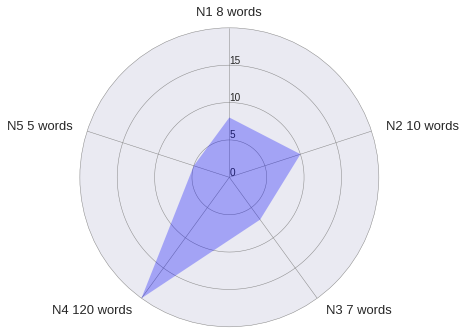

In [174]:
import seaborn
from math import pi
import matplotlib.pyplot as plt

words_in_clstrs = [8, 10, 7, 20, 5]
words_in_clstrs2 = [8, 10, 7, 120, 5]
# Set data
cat = ['1','2','3','4','5']
values = words_in_clstrs

N = len(cat)

x_as = [n / float(N) * 2 * pi for n in range(N)]

# Because our chart will be circular we need to append a copy of the first 
# value of each list at the end of each list with data
values += values[:1]
x_as += x_as[:1]


# Set color of axes
plt.rc('axes', linewidth=0.5, edgecolor="#888888")


# Create polar plot
ax = plt.subplot(111, polar=True)


# Set clockwise rotation. That is:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)


# Set position of y-labels
ax.set_rlabel_position(0)


# Set color and linestyle of grid
ax.xaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)
ax.yaxis.grid(True, color="#888888", linestyle='solid', linewidth=0.5)


# Set number of radial axes and remove labels
plt.xticks(x_as[:-1], [])

# Set yticks
plt.yticks([0, 5, 10, 15], ["0", '5', "10", "15"])


# Plot data
ax.plot(x_as, values, linewidth=0, linestyle='solid', zorder=3)

# Fill area
ax.fill(x_as, values, 'b', alpha=0.3)

size_of_radar =20
# Set axes limits
plt.ylim(0, size_of_radar)

# Draw ytick labels to make sure they fit properly
for i in range(N):
    angle_rad = i / float(N) * 2 * pi

    if angle_rad == 0:
        ha, distance_ax = "center", 1
    elif 0 < angle_rad < pi:
        ha, distance_ax = "left", 1
    elif angle_rad == pi:
        ha, distance_ax = "center", 1
    else:
        ha, distance_ax = "right", 1

    ax.text(angle_rad, 21 + distance_ax, 'N'+str(cat[i])+' '+str(words_in_clstrs2[i])+' words', size=13, horizontalalignment=ha, verticalalignment="center")

# Draw ytick labels to make sure they fit properly
plt.savefig('filename_uk.png', dpi = 140)

# Show polar plot
plt.show()

In [90]:
result_with_syn[0]

['budgetary',
 'amalgamate, fused, consolidate, consolidated, amalgamated, coalesced',
 'osmium, atomic_number_76, Os',
 'foreign, strange, alien, extraneous',
 'switch, swap, swop, merchandise, patronage, craft, business_deal, trade, trade_in, trade_wind, deal, barter, sell',
 '',
 'municipality',
 'real, rattling, really, tangible, veridical, material, substantial, very, genuine, literal, existent, real_number, actual']

In [89]:
#Распределение кластеров
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

x= []
y= []
averg=[]
mm = 0
matrix = result_with_syn[0]
for _ in range(20):
    for nc in range(10, 3,-1):
            kmean = KMeans(n_clusters=nc)
            rez=kmean.fit_predict(matrix) 
            silhouette_avg = silhouette_score(matrix, rez)
            x.append(nc)
            y.append(silhouette_avg)
            print('clust=',nc,'silh=',silhouette_avg)

        
        
#    df['clst'] = x
#    df['coef'] = y
#    x= []
#    y= []
#    averg.append(df.loc[df['coef'].idxmax()]['clst'])
#sum(averg)/len(averg)

ValueError: could not convert string to float: 'budgetary'

In [316]:
dtm.shape

(105, 1361)

In [314]:
dtm = dtm.T

In [313]:
kmean = KMeans(n_clusters=10)
rez=kmean.fit_predict(dtm) 
print('clust=',10,'silh=',silhouette_score(dtm, rez))


clust= 10 silh= 0.0732165802112


In [224]:
kmean = KMeans(n_clusters=10).fit(dtm)
kmean.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

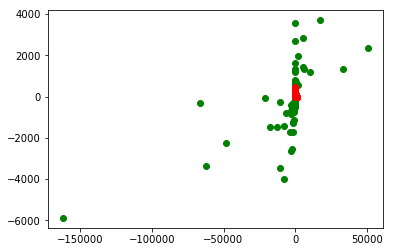

In [487]:
plt.plot(ux,uy, marker='o', color='g', ls='')
plt.plot(x,y, marker='o', color='r', ls='')
plt.show()

In [488]:
r = []
for i in range(len(nomer)):
    r.append(((ux[i]*-x[i])**2+(uy[i]*-y[i])**2)**0.5)

In [10]:
#Токенизация
ru_ls= []
for i in range(len(ru)):
    ru_ls.append(ru[i].split(' '))


In [58]:
#Синонимы
z= [[],[]]
ind=-1
for i in ru_ls:
    print(i)
    ind +=1
    print(ind)
    for a in i:
        print(a,'-------')
        for synset in wn.synsets(a):
            for lemma in synset.lemmas():
                z[ind].append(lemma.name())

['the', 'organization', 'to', 'be', 'under', 'the', 'jurisdiction', 'of', 'the', 'Ministry', 'of', 'Finance', 'Russia', 'list', '', 'and', 'the', 'function', 'of', 'the', 'organization', 'to', 'be', 'under', 'the', 'jurisdiction', 'of', 'the', 'Ministry', 'of', 'Finance', '', 'Russia', 'field', 'name', 'english', 'description', 'English', 'description', 'format', 'name', 'of', 'the', 'organization', 'Name', 'of', 'the', 'organization', 'name', 'of', 'the', 'organization', 'to', 'be', 'under', 'the', 'jurisdiction', 'of', 'the', 'Ministry', 'of', 'Finance', 'Russia', 'string', 'head', 'organization', 'of', 'the', 'CEO', '', 'the', 'head', 'of', 'the', 'string', 'legal', 'address', 'Legal', 'address', 'legal', 'address', 'legal', 'address', 'string', 'code', 'kladr', 'KLADR', 'Legal', 'address', 'the', 'legal', 'address', 'of', 'the', 'string', 'kladr', 'code', 'postal', 'address', 'Postal', 'address', 'postal', 'address', 'postal', 'address', 'string', 'code', 'kladr', 'KLADR', 'Postal'

 -------
report -------


IndexError: list index out of range

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 2, ..., 1, 1, 4],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=int64)

In [64]:
import numpy as np
U, s, V = np.linalg.svd(tdm, full_matrices=True)

In [65]:
import pandas as pd

dfU = pd.DataFrame(U, index=vectorizer.get_feature_names() )
dfV = pd.DataFrame(V)


In [67]:
dfU[[1,2,3]]

,1,2,3
abbreviated,-0.000039,0.000142,0.001162
about,0.004000,-0.004269,0.046473
academic,0.002673,-0.000138,-0.000379
academicdegree,0.002673,-0.000138,-0.000379
academy,-0.000007,0.000041,0.000819
acap,-0.000282,0.000304,0.004552
acceptance,-0.000059,0.000012,0.000767
access,-0.000127,0.000146,0.001816
accommodation,-0.000107,0.000081,0.001325
accordance,-0.001590,0.004204,0.009933


In [66]:
dfV.iloc[[1,2]]

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
1,-0.007257,0.034809,0.035193,-0.013210,-0.002468,-0.009688,-0.004063,-0.006397,-0.006713,-0.007762,...,-0.005444,-0.048055,-0.037256,0.000960,-0.003635,-0.017434,-0.008460,-0.002718,-0.005527,-0.009607
2,0.005040,0.020590,0.007395,-0.010482,-0.011348,0.000039,-0.004217,0.005101,0.002313,0.002308,...,-0.002762,0.038221,-0.010987,0.007644,0.000457,-0.009073,0.025682,0.007112,0.009241,0.005604


In [10]:
#%matplotlib inline
#from pandas.tools.plotting import scatter_matrix
#scatter_matrix(dfV, alpha=0.1, figsize=(12, 12), diagonal='kde')

In [68]:
def f1(x):
    if abs(x)<0.1: 
        return 0  
    return x


Выше показаны ключевые образы их три 1-ая компонента самая сильная, вторая послабей и последняя самая слабая.
Действительно текст первой компоненты повторяется чаще всего.

In [33]:
list(map(f1,dfV[0] ))

[0, -0.57735026918962573, 0, 0, -0.81649658092772615, 0, 0, 0]

Первая компонента говорит, что  стоит взять 2 и 5 
предложения - остальные похожи на эти два, 
скорее всего или на одно или на другое 

In [74]:
np.savetxt('nump.out', tdm, delimiter=',',fmt = )

In [80]:
from io import StringIO  
numps = StringIO("0 1\n2 3")
np.loadtxt(numps).shape


(2, 2)

In [13]:
KMeans()

[0, -0.57735026918962584, 0, 0.70441146084575823, 0.40824829046386291, 0, 0, 0]

В третье компоненте есть различия. Это  показывает что слова образуют две устойчивые группы по повтояемости, то есть две темы.

In [73]:
from sklearn.cluster import KMeans

import numpy as np

import bokeh.plotting

from bokeh.plotting import figure

from sklearn import datasets

bokeh.plotting.output_notebook()  

iris = datasets.load_iris()

petal_data = tdm 

kmean = KMeans() #n_clusters asks for only 3 groupings

kmean.fit(petal_data) 

plot = figure(width=500, height=500, title='Ru', x_axis_label = "X", y_axis_label = "Y")

#plot centroid / cluster center / group mean for each group

clus_xs = []

clus_ys = []

#we get the  cluster x / y values from the k-means algorithm

for entry in kmean.cluster_centers_:

   clus_xs.append(entry[0])

   clus_ys.append(entry[1])

#the cluster center is marked by a circle, with a cross in it

plot.circle_cross(x=clus_xs, y=clus_ys, size=40, fill_alpha=0, line_width=2, )

plot.text(x=clus_xs, y=clus_ys, text_font_size='30pt')

i = 0 #counter

 

for sample in petal_data:

 
   if kmean.labels_[i] == 0:
        plot.circle(x=sample[0], y=sample[1], size=15, color="red")

   if kmean.labels_[i] == 1:
    plot.circle(x=sample[0], y=sample[1], size=15, color="blue")

   if kmean.labels_[i] == 2:
    plot.circle(x=sample[0], y=sample[1], size=15, color="purple")

   i += 1

bokeh.plotting.show(plot)


Loading BokehJS ...

KeyboardInterrupt: 

In [ ]:

from sklearn.cluster import KMeans

import numpy as np

import bokeh.plotting

from bokeh.plotting import figure

from sklearn import datasets

bokeh.plotting.output_notebook()  

iris = datasets.load_iris()

petal_data = iris.data[:,2:] 

kmean = KMeans(n_clusters=3) #n_clusters asks for only 3 groupings

kmean.fit(petal_data) 

plot = figure(width=500, height=500, title='Iris Petals', x_axis_label = "Petal Length", y_axis_label = "Petal Width")

#plot centroid / cluster center / group mean for each group

clus_xs = []

clus_ys = []

#we get the  cluster x / y values from the k-means algorithm

for entry in kmean.cluster_centers_:

   clus_xs.append(entry[0])

   clus_ys.append(entry[1])

#the cluster center is marked by a circle, with a cross in it

plot.circle_cross(x=clus_xs, y=clus_ys, size=40, fill_alpha=0, line_width=2, color=['red', 'blue', 'purple'])

plot.text(text = ['setosa', 'versicolor', 'virginica'], x=clus_xs, y=clus_ys, text_font_size='30pt')

i = 0 #counter

 

for sample in petal_data:

 
   if kmean.labels_[i] == 0:
        plot.circle(x=sample[0], y=sample[1], size=15, color="red")

   if kmean.labels_[i] == 1:
    plot.circle(x=sample[0], y=sample[1], size=15, color="blue")

   if kmean.labels_[i] == 2:
    plot.circle(x=sample[0], y=sample[1], size=15, color="purple")

   i += 1

bokeh.plotting.show(plot)


Loading BokehJS ...

In [84]:
iris.data[:,2:] 

NameError: name 'iris' is not defined